<a href="https://colab.research.google.com/github/cipher982/GNN-playground/blob/main/dgl_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Neural Networks
By David Rose

# Graphs TL;DR

## What?
A graph is a method of representing a network data and the connections between. In the most basic form you have two parts that make up a graph: **nodes** and **edges**.

The nodes represent the samples of data and the edges represent some sort of link between them. Sometimes the link can be a single obvious property connecting multiple objects such as:
- Distances between cities in miles
- Friendships on Facebook
- Citations between papers on Arxiv

Or sometimes the network can be connected by multiple relevant attributes. With the Amazon goods supply chain you will have numeroud routes that can be described by:
- The trucks that deliver on routes between warehouses
- The type of route (sea, land, air)
- The average time or cost to transfer between locations

## Why?
Compared to tabular datasets there is no assumption of IID, rather the intent with graphs is the express purpose of the samples of data being related in some way or another. 

## How?
We can transition a graph to the form of a typical machine learning problem by giving both the nodes and the edges their own features, and then performing the task of classifying a label on a specific node or a graph as a whole. Maybe for COVID contact tracing we are wanting to find who may have had contact with a specific person (node) but we only have partial knowledge of contact so far (the labels true/false) based on the edge features (distance in where they live) and node features (demographics, job type, common locations visited).

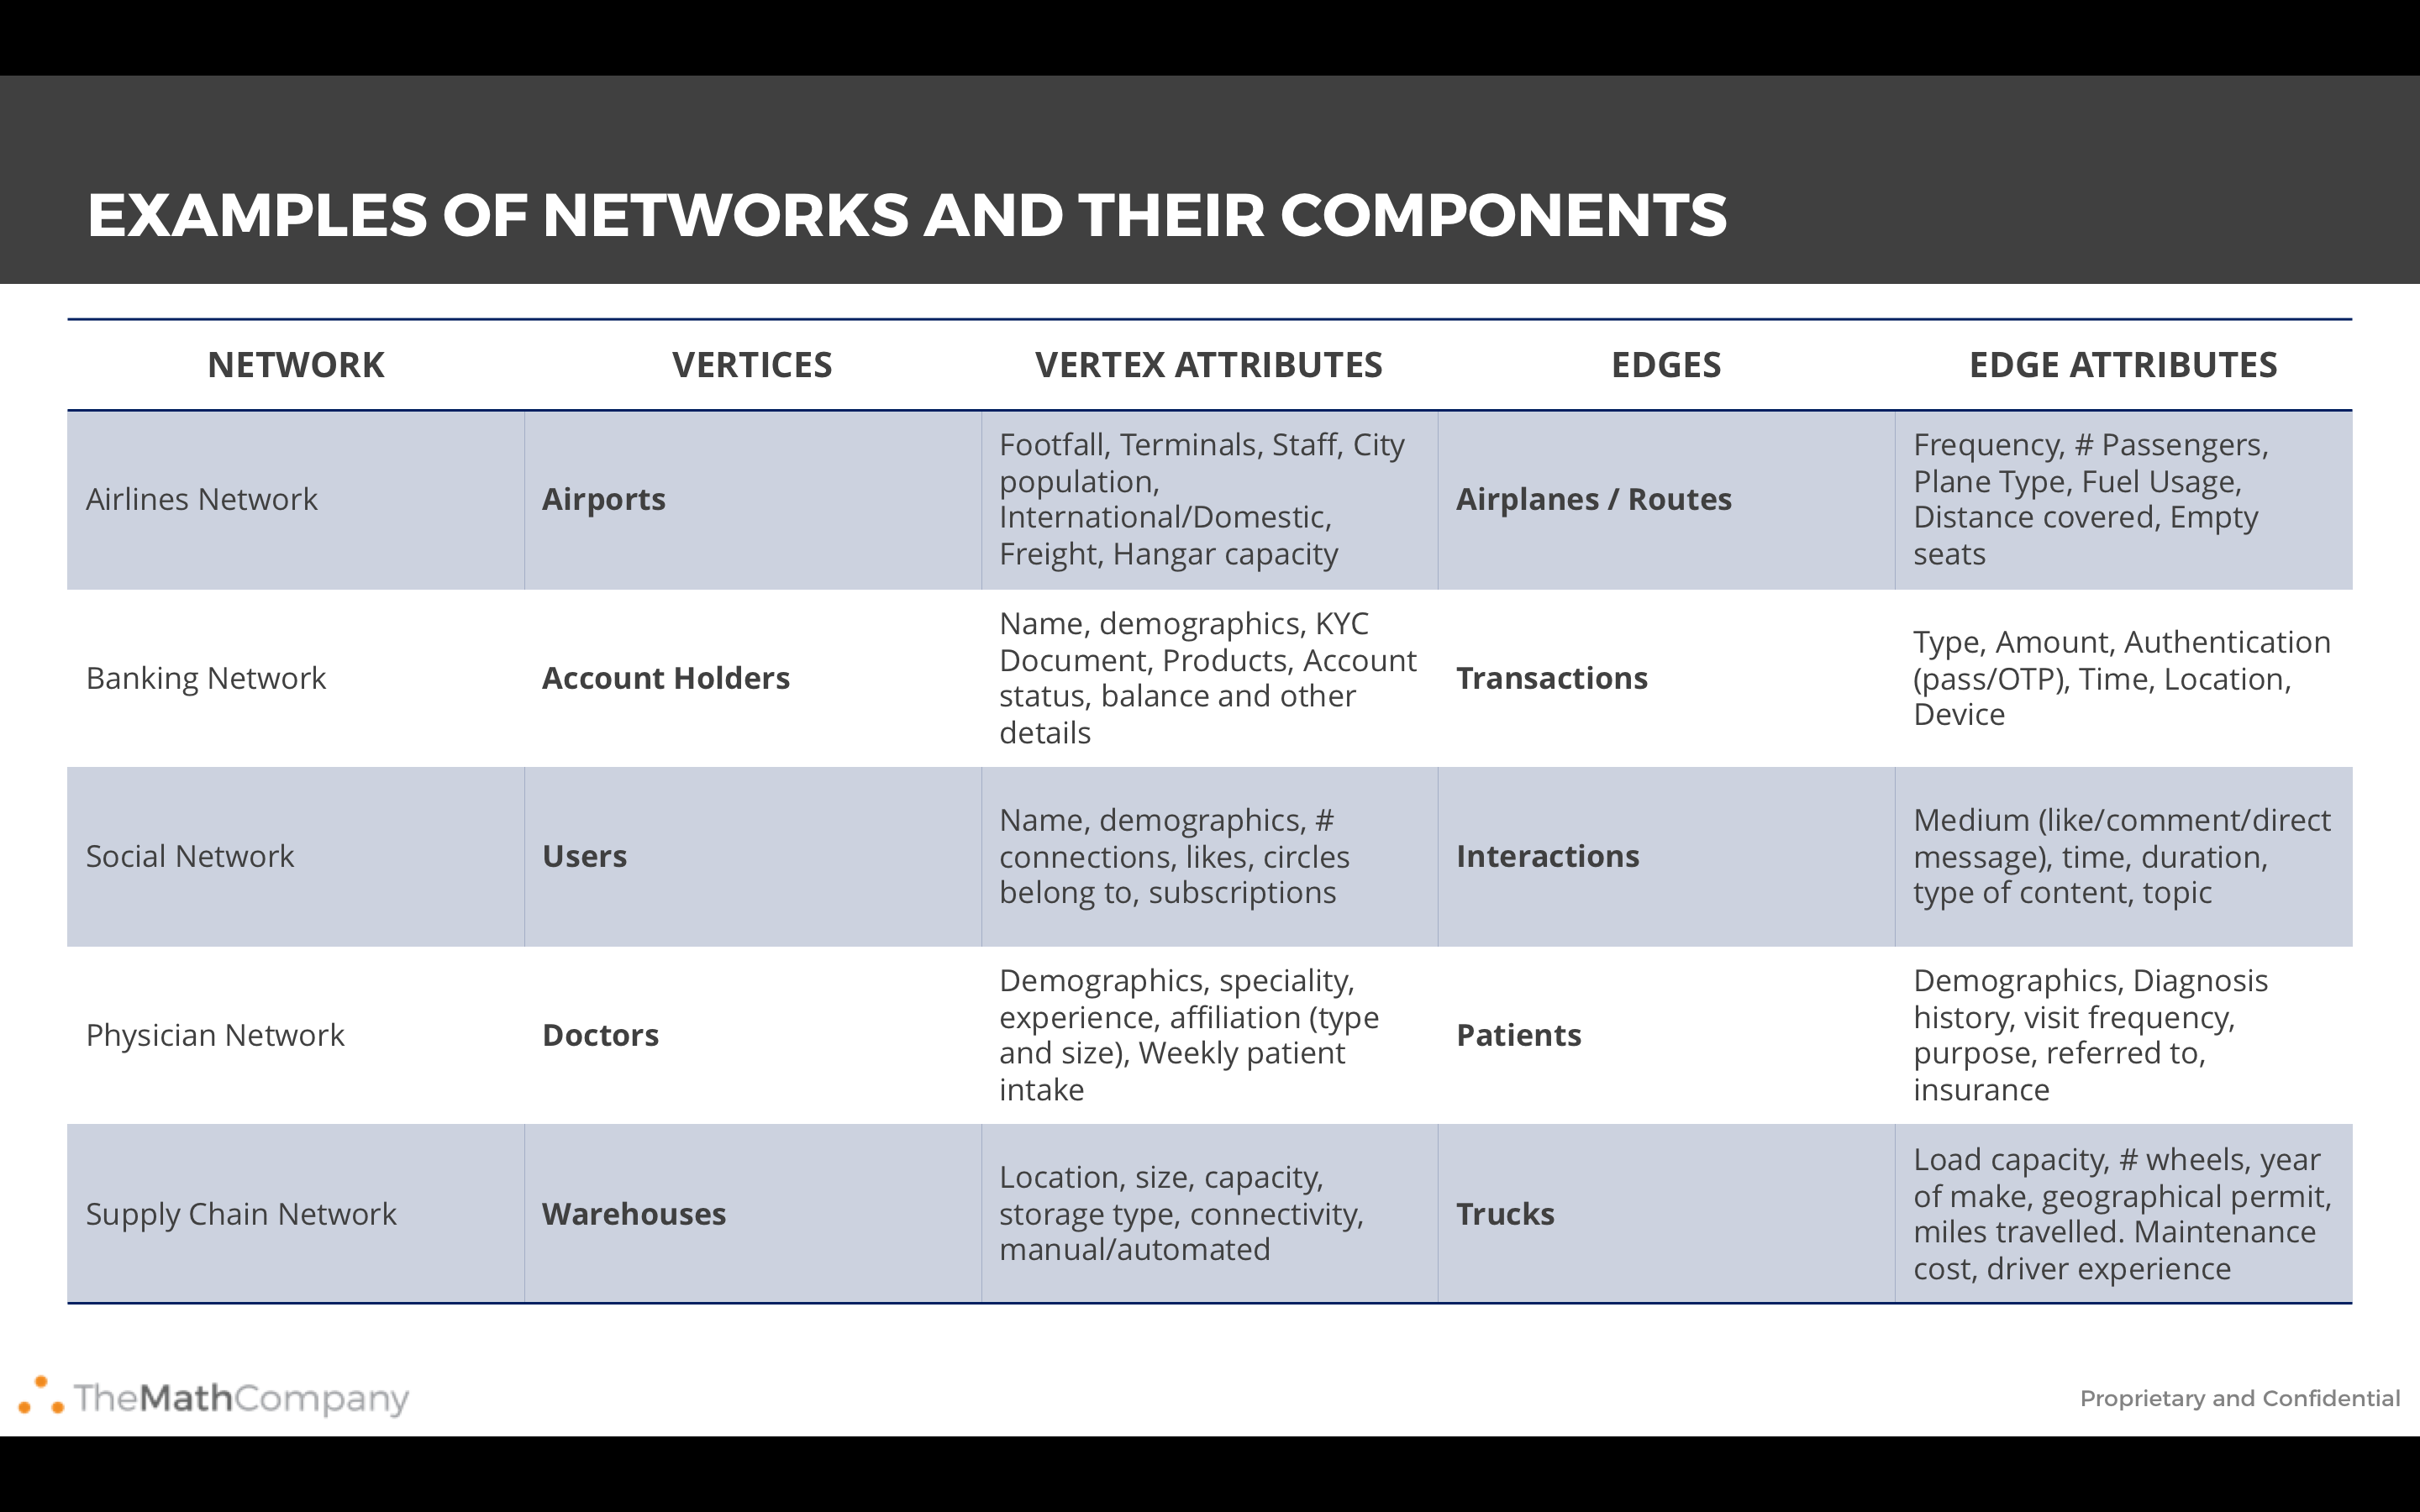

# History

The first mention was in 2009 in a paper from the University of Wollongong, Australia. They proposed the idea of a *Graph Neural Network Model* 

In [ ]:
!pip install dgl > bash_log.txt

In [ ]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl.data

#%env DGLBACKEND='tensorflow'
%env DGLBACKEND='pytorch'

USE_GPU = False

env: DGLBACKEND='pytorch'


In [ ]:
dataset = dgl.data.CoraGraphDataset()
print('Number of categories:', dataset.num_classes)

g = dataset[0]
print('\nNode features')
print(g.ndata)
print('\nEdge features')
print(g.edata)

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
Number of categories: 7

Node features
{'feat': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), 'label': tensor([3, 4, 4,  ..., 3, 3, 3]), 'test_mask': tensor([False, False, False,  ...,  True,  True,  True]), 'train_mask': tensor([ True,  True,  True,  ..., False, False, False]), 'val_mask': tensor([False, False, False,  ..., False, False, False])}

Edge features
{}


In [ ]:
from dgl.nn import GraphConv

class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

# Create the model with given dimensions
model = GCN(g.ndata['feat'].shape[1], 16, dataset.num_classes)

In [ ]:
def train(g, model):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    best_val_acc = 0
    best_test_acc = 0

    features = g.ndata['feat']
    labels = g.ndata['label']
    train_mask = g.ndata['train_mask']
    val_mask = g.ndata['val_mask']
    test_mask = g.ndata['test_mask']
    for e in range(50):
        # Forward
        logits = model(g, features)

        # Compute prediction
        pred = logits.argmax(1)

        # Compute loss
        # Only compute the losses of the nodes in the training set
        loss = F.cross_entropy(logits[train_mask], labels[train_mask])

        # Compute accuracy on training/validation/test
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

        # Save best validation accuracy and corresponding test accuracy
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % 5 == 0:
            print(
            'epoch {}, loss: {:.3f}, val acc: {:.3f} (best {:.3f}),\
            test acc: {:.3f} (best {:.3f})'.format(
                e, loss, val_acc, best_val_acc, test_acc, best_test_acc))

if USE_GPU:            
    g = g.to('cuda')
    model = GCN(g.ndata['feat'].shape[1], 16, dataset.num_classes).to('cuda')
else:
    model = GCN(g.ndata['feat'].shape[1], 16, dataset.num_classes)

train(g, model)

epoch 0, loss: 1.946, val acc: 0.102 (best 0.102),            test acc: 0.109 (best 0.109)
epoch 5, loss: 1.888, val acc: 0.422 (best 0.422),            test acc: 0.471 (best 0.471)
epoch 10, loss: 1.803, val acc: 0.552 (best 0.552),            test acc: 0.583 (best 0.583)
epoch 15, loss: 1.693, val acc: 0.612 (best 0.612),            test acc: 0.620 (best 0.620)
epoch 20, loss: 1.559, val acc: 0.672 (best 0.672),            test acc: 0.671 (best 0.671)
epoch 25, loss: 1.405, val acc: 0.692 (best 0.692),            test acc: 0.702 (best 0.702)
epoch 30, loss: 1.236, val acc: 0.712 (best 0.712),            test acc: 0.720 (best 0.717)
epoch 35, loss: 1.062, val acc: 0.718 (best 0.718),            test acc: 0.728 (best 0.726)
epoch 40, loss: 0.891, val acc: 0.730 (best 0.730),            test acc: 0.749 (best 0.746)
epoch 45, loss: 0.733, val acc: 0.732 (best 0.734),            test acc: 0.753 (best 0.753)


In [36]:
g

[Graph(num_nodes=2708, num_edges=10556,
       ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'feat': Scheme(shape=(1433,), dtype=torch.float32), 'test_mask': Scheme(shape=(), dtype=torch.uint8), 'val_mask': Scheme(shape=(), dtype=torch.uint8), 'train_mask': Scheme(shape=(), dtype=torch.uint8)}
       edata_schemes={})]

In [37]:
# Save graphs
dgl.save_graphs('graph.dgl', g)

# Load graphs
(g,), _ = dgl.load_graphs('graph.dgl')
print(g)

Graph(num_nodes=2708, num_edges=10556,
      ndata_schemes={'train_mask': Scheme(shape=(), dtype=torch.uint8), 'val_mask': Scheme(shape=(), dtype=torch.uint8), 'test_mask': Scheme(shape=(), dtype=torch.uint8), 'label': Scheme(shape=(), dtype=torch.int64), 'feat': Scheme(shape=(1433,), dtype=torch.float32)}
      edata_schemes={})


# Reddit Dataset

In [38]:
reddit = dgl.data.RedditDataset()

Extracting file to /root/.dgl/reddit


In [49]:
graph = reddit[0]
graph

Graph(num_nodes=232965, num_edges=114615892,
      ndata_schemes={'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'feat': Scheme(shape=(602,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={})

In [50]:
print(dir(graph))

['__class__', '__contains__', '__copy__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_batch_num_edges', '_batch_num_nodes', '_canonical_etypes', '_dsttypes_invmap', '_edge_frames', '_etype2canonical', '_etypes', '_etypes_invmap', '_find_etypes', '_get_e_repr', '_get_n_repr', '_graph', '_idtype_str', '_init', '_is_unibipartite', '_node_frames', '_ntypes', '_pop_e_repr', '_pop_n_repr', '_reset_cached_info', '_set_e_repr', '_set_n_repr', '_srctypes_invmap', 'add_edge', 'add_edges', 'add_nodes', 'add_self_loop', 'adj', 'adjacency_matrix', 'adjacency_matrix_scipy', 'all_edges', 'apply_edges', 'apply_nodes', 'astype', 'batch_num_edges', 'batch_num_nodes', 'batch_size

In [55]:
reddit.num_classes

41

In [56]:
reddit.num_labels

/usr/local/lib/python3.7/dist-packages/dgl/data/utils.py:285: UserWarning: Property dataset.num_labels will be deprecated, please use dataset.num_classes instead.
  warnings.warn('Property {} will be deprecated, please use {} instead.'.format(old, new))


41

In [58]:
graph.ndata

{'train_mask': tensor([False,  True, False,  ...,  True,  True, False]), 'val_mask': tensor([False, False, False,  ..., False, False, False]), 'test_mask': tensor([ True, False,  True,  ..., False, False,  True]), 'feat': tensor([[ 1.2334,  9.0430, -0.9233,  ..., -0.2579,  0.3112, -0.3772],
        [-0.1386, -0.2022,  0.1277,  ...,  0.1563,  0.1048, -0.6534],
        [-0.1330, -0.1962, -0.0296,  ...,  0.0358,  0.2864,  0.2744],
        ...,
        [-0.0614, -0.2022,  0.9698,  ...,  1.1064, -1.4323, -0.2398],
        [-0.1606, -0.2022, -0.0892,  ...,  0.7440, -0.5046, -2.2288],
        [ 0.0929,  0.2822,  0.1768,  ...,  0.2196,  0.5967,  0.5588]]), 'label': tensor([30, 17, 18,  ...,  3, 13, 13])}

In [59]:
graph.edata

{}